<h1 align="center">AI Assistants Intro</h1>

---

<center><h2>Lesson 04</h2></center>


#### **Intro to Supervised Machine Learning: Decision Trees + Workflow**

- Define supervised learning and its key pieces (features, labels, training).
- Explain classification vs regression.
- Describe decision trees and how they make decisions.
- Implement a decision tree in scikit-learn.
- Correctly do train/val/test splits and evaluate a simple model.


![Machine Learning Types](../../files/machine_learning_types.png)


### What is Supervised Learning?

Supervised learning pairs labeled examples with an algorithm that learns how to map inputs to outputs. Once trained, the model can make predictions on new, unseen data.

**Key pieces**

- **Dataset**: collection of examples we care about.
- **Features (`x`)**: measurable inputs like heart rate, pixels, or number of people on each track.
- **Labels (`y`)**: correct answers provided by humans, instruments, or previous experiments.
- **Model**: algorithm (decision tree, neural net, etc.) that learns a mapping from features to labels.
- **Training**: process of adjusting the model based on data so predictions get closer to true labels.
- **Evaluation**: how we score the model’s predictions (e.g., accuracy, mean squared error) to decide if it is good enough or needs improvement.

**Classification vs. regression**

- Classification predicts categories (e.g., "tumor is benign or malignant").
- Regression predicts continuous numbers (e.g., blood glucose level in mg/dL).

**The feedback loop**
Data → Model → Predictions → Compare to Labels → Learn → Repeat


## The Titanic Dataset

![Titanic Depiction](../../files/titanic.jpg)

**https://www.kaggle.com/datasets/yasserh/titanic-dataset**


We’ll use the classic **Titanic survival** dataset as a supervised learning problem.

We can frame it as supervised learning:

- **Inputs/features**: passenger info like class (`pclass`), sex, age, fare, and port of embarkation.
- **Output/label**: whether the passenger **survived** (`1`) or **did not survive** (`0`).
- This dataset is historical and widely used for teaching ML workflows (it is not a “fairness benchmark”).


### Dataset Preview

We’ll load the dataset into a DataFrame and inspect a few rows to understand the columns and missing values.


In the Titanic dataset, we’ll use a small set of human-readable features to predict survival:

- `pclass`: passenger class (1st, 2nd, 3rd).
- `sex`: passenger sex.
- `age`: passenger age (years; may have missing values).
- `sibsp`: number of siblings/spouses aboard.
- `parch`: number of parents/children aboard.
- `fare`: ticket price.
- `embarked`: port of embarkation (C/Q/S).

The label we want to predict is:

- `survived`: `1` if the passenger survived, `0` otherwise.


### ✏️ Exercise: Copy the prompt below into copilot chat to load the Titanic Dataset

#### **Prompt:**

Load the titanic dataset as a dataframe using fetch_openml


In [3]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Fetch Titanic dataset from OpenML
titanic = fetch_openml(
    name="titanic",
    version=1,
    as_frame=True
)

# Extract DataFrame
df = titanic.frame

# Quick inspection
print(df.shape)
df.head()


(1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### ✏️ Exercise: Visualize the Titanic Dataset

#### **Prompt:**

Create a clean, well-organized Plotly figure with multiple subplots to visualize key metrics from the Titanic dataset. Use a single figure with clearly labeled subplots showing: (1) survival counts, (2) survival rate by sex, (3) survival rate by passenger class, and (4) age distribution split by survival status. Ensure consistent styling across subplots, readable axis labels and titles, and an overall layout suitable for teaching (minimal clutter, clear legends, and appropriate spacing).


In [ ]:
# Plotly multi-panel view of Titanic survival patterns
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Clean + standardize columns we need (robust to OpenML dtypes / missing values) ---
required_cols = ["survived", "sex", "pclass", "age"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Titanic df is missing expected columns: {missing}")

df_viz = df[required_cols].copy()
df_viz["survived"] = pd.to_numeric(df_viz["survived"], errors="coerce")
df_viz = df_viz.dropna(subset=["survived"]).copy()
df_viz["survived"] = df_viz["survived"].astype(int)

df_viz["sex"] = df_viz["sex"].astype("string").str.strip().str.lower().fillna("unknown")
df_viz.loc[~df_viz["sex"].isin(["male", "female"]), "sex"] = "unknown"

df_viz["pclass"] = pd.to_numeric(df_viz["pclass"], errors="coerce")
df_viz["age"] = pd.to_numeric(df_viz["age"], errors="coerce")

label_map = {0: "Died (0)", 1: "Survived (1)"}
color_map = {0: "#d62728", 1: "#2ca02c"}  # red / green (teaching-friendly)

# --- Aggregate metrics ---
counts = (
    df_viz["survived"]
    .value_counts()
    .reindex([0, 1], fill_value=0)
)
sex_order = ["female", "male", "unknown"]
survival_rate_by_sex = (
    df_viz.groupby("sex")["survived"].mean()
    .reindex(sex_order)
    .dropna()
)
survival_rate_by_pclass = (
    df_viz.dropna(subset=["pclass"]).groupby("pclass")["survived"].mean().sort_index()
)

pclass_labels = {1.0: "1st", 2.0: "2nd", 3.0: "3rd"}
pclass_x = [pclass_labels.get(float(v), str(int(v)) if float(v).is_integer() else str(v)) for v in survival_rate_by_pclass.index]

# --- Build 2x2 subplot figure ---
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        "(1) Survival counts",
        "(2) Survival rate by sex",
        "(3) Survival rate by passenger class",
        "(4) Age distribution by survival status",
    ),
)

# (1) Survival counts
fig.add_trace(
    go.Bar(
        x=[label_map[0], label_map[1]],
        y=[counts.loc[0], counts.loc[1]],
        marker_color=[color_map[0], color_map[1]],
        text=[counts.loc[0], counts.loc[1]],
        textposition="outside",
        hovertemplate="%{x}<br>Count: %{y}<extra></extra>",
        name="Counts",
        showlegend=False,
    ),
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Passengers", row=1, col=1)

# (2) Survival rate by sex
fig.add_trace(
    go.Bar(
        x=[s.title() for s in survival_rate_by_sex.index],
        y=survival_rate_by_sex.values,
        marker_color="#1f77b4",
        text=[f"{v:.0%}" for v in survival_rate_by_sex.values],
        textposition="outside",
        hovertemplate="Sex: %{x}<br>Survival rate: %{y:.1%}<extra></extra>",
        name="Survival rate",
        showlegend=False,
    ),
    row=1,
    col=2,
)
fig.update_yaxes(title_text="Survival rate", tickformat=".0%", range=[0, 1], row=1, col=2)

# (3) Survival rate by passenger class
fig.add_trace(
    go.Bar(
        x=pclass_x,
        y=survival_rate_by_pclass.values,
        marker_color="#9467bd",
        text=[f"{v:.0%}" for v in survival_rate_by_pclass.values],
        textposition="outside",
        hovertemplate="Class: %{x}<br>Survival rate: %{y:.1%}<extra></extra>",
        name="Survival rate",
        showlegend=False,
    ),
    row=2,
    col=1,
)
fig.update_xaxes(title_text="Passenger class", row=2, col=1)
fig.update_yaxes(title_text="Survival rate", tickformat=".0%", range=[0, 1], row=2, col=1)

# (4) Age distribution split by survival status (overlayed histograms)
age_bins = dict(start=0, end=80, size=5)
for survived_value in [0, 1]:
    age_series = df_viz.loc[df_viz["survived"] == survived_value, "age"].dropna()
    fig.add_trace(
        go.Histogram(
            x=age_series,
            xbins=age_bins,
            opacity=0.6,
            marker_color=color_map[survived_value],
            name=label_map[survived_value],
            hovertemplate="Age bin count: %{y}<extra></extra>",
        ),
        row=2,
        col=2,
    )
fig.update_xaxes(title_text="Age (years)", row=2, col=2)
fig.update_yaxes(title_text="Passengers", row=2, col=2)
fig.update_layout(barmode="overlay")

# --- Global styling (teaching-friendly) ---
fig.update_layout(
    title=dict(text="Titanic dataset overview (Plotly subplots)", x=0.5),
    template="plotly_white",
    height=750,
    width=1000,
    margin=dict(l=60, r=30, t=90, b=60),
    legend=dict(
        title="",
        orientation="h",
        yanchor="top",
        y=-0.12,
        xanchor="center",
        x=0.5,
    ),
)
fig.update_annotations(font_size=13)
fig.show()

Decision trees break decisions into small yes/no questions until they reach a conclusion. A tiny (illustrative) tree for Titanic might look like:

```
Start
├─ Is sex == female? → Yes → Predict Survived
└─ No
   ├─ Is pclass == 1? → Yes → Predict Survived
   └─ No → Predict Did Not Survive
```

Each question corresponds to a split on one feature, and the final prediction is a **leaf node**.

**Check-your-understanding**

1. Which feature do you think a tree should split on first for Titanic? Why?
2. What does a “leaf” represent in a decision tree?


# Decision Trees

A **decision tree** is a supervised machine learning model that makes predictions by asking a sequence of simple **if/then** questions about the input features.

## How it works

- The tree starts at the **root** (the first question).
- Each question applies a **split rule** (e.g., `age < 15`, `sex == "female"`).
- Splits create **branches** that route examples into smaller groups.
- The process continues until reaching a **leaf**, which outputs the final prediction:
  - **Classification**: a class label (e.g., survived vs. not survived)
  - **Regression**: a numeric value

## Why people like decision trees

- **Interpretable**: you can explain a prediction by tracing the path of decisions taken.
- **Flexible features**: works with both **numeric** and **categorical** inputs.
- **Handles nonlinearity**: can capture nonlinear patterns without feature scaling.


![Decision Tree](../../files/decision_tree.png)


### ✏️ Exercise: Build a Simple Classifier by Hand

Before we train a real model, we’ll build a tiny **rule-based baseline**. This mimics the idea of a decision tree split without doing any optimization.

**Rules (use these exactly in your code):**

1. If `sex == "female"`, predict `survived = 1`.
2. Else if `age < 15`, predict `survived = 1`.
3. Otherwise, predict `survived = 0`.

We’ll then compute the accuracy of this heuristic on the dataset.


#### **Prompt:**

Implement and evaluate a simple heuristic baseline for Titanic survival using a dataframe called df. Assume df includes the columns survived, sex, age, and pclass, even if the values are missing or inconsistently formatted. Define a function predict_survival(row) that predicts survival by returning 1 if the passenger is female (case-insensitive), otherwise returning 1 if the passenger’s age can be parsed as a number and is under 15, and returning 0 in all other cases. Convert both age and survived to numeric using pd.to_numeric(..., errors="coerce"), add the predictions to the dataframe as a new column called rule_pred using df.apply(..., axis=1), and compute accuracy only for rows where survived is not missing. Finally, print the accuracy with a clear label and display the first 10 rows showing survived, sex, age, pclass, and rule_pred.


In [5]:
# Implement the heuristic baseline from the prompt above

def predict_survival(row):
    sex = str(row.get("sex", "")).lower()
    age = pd.to_numeric(row.get("age", pd.NA), errors="coerce")

    if sex == "female":
        return 1
    if pd.notna(age) and float(age) < 15:
        return 1
    return 0

df["rule_pred"] = df.apply(predict_survival, axis=1)

# Ensure the label is numeric 0/1
y_true = pd.to_numeric(df["survived"], errors="coerce")
mask = y_true.notna()
rule_accuracy = (df.loc[mask, "rule_pred"] == y_true.loc[mask].astype(int)).mean()

print(f"Heuristic baseline accuracy (rows with non-missing label): {rule_accuracy:.2f}")
df[["survived", "sex", "age", "pclass", "rule_pred"]].head(10)

Heuristic baseline accuracy (rows with non-missing label): 0.78


,survived,sex,age,pclass,rule_pred
0,1,female,29.0000,1,1
1,1,male,0.9167,1,1
2,0,female,2.0000,1,1
3,0,male,30.0000,1,0
4,0,female,25.0000,1,1
5,1,male,48.0000,1,0
6,1,female,63.0000,1,1
7,0,male,39.0000,1,0
8,1,female,53.0000,1,1
9,0,male,71.0000,1,0


This tiny heuristic is a baseline, but it will miss many patterns and interactions in the data. Rather than hand-coding every rule, we let ML algorithms search through many possible splits and automatically build trees with a consistent strategy.


### Create a Decision Tree Classifier

`scikit-learn` is a widely used Python library that standardizes ML workflows. The pattern is predictable:

1. Import the model class.
2. Create a model instance (optionally set hyperparameters).
3. Fit on training data (learn patterns).
4. Predict on data.
5. Evaluate with a metric such as accuracy.


### ✏️ Exercise: Prepare the Titanic Dataset for Decision Tree Modeling

#### **Prompt:**

Prepare the Titanic dataset for a Decision Tree model using pandas and scikit-learn, assuming a dataframe df already exists. Use the features pclass, sex, age, sibsp, parch, fare, and embarked, with survived as the label. Create a clean modeling dataframe containing only these columns, convert all numeric fields and the label to numeric values using pd.to_numeric(..., errors="coerce"), and apply simple, transparent imputation by filling missing numeric values with the median and missing categorical values with the mode (or "unknown" if no mode exists), ensuring categorical strings are lowercased. Drop any rows with missing labels, one-hot encode the categorical variables so they can be used by a decision tree, and then construct the feature matrix X and label vector y. Finally, print the shape of X, display the distribution of the labels, and show the first few rows of X, keeping the code clean and readable for instructional use.


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Build a clean feature matrix X and label vector y for a decision tree
import numpy as np
import pandas as pd

# Select the features we described in the lesson (human-readable + mixed types)
feature_cols = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
label_col = "survived"

# Keep only the columns we need
df_model = df[feature_cols + [label_col]].copy()

# Coerce numerics (OpenML titanic can contain strings/object dtypes)
for c in ["pclass", "age", "sibsp", "parch", "fare"]:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

# Coerce label to numeric 0/1
df_model[label_col] = pd.to_numeric(df_model[label_col], errors="coerce")

# Basic imputation (simple + transparent for teaching)
numeric_cols = ["pclass", "age", "sibsp", "parch", "fare"]
categorical_cols = ["sex", "embarked"]

for c in numeric_cols:
    df_model[c] = df_model[c].fillna(df_model[c].median())

for c in categorical_cols:
    # mode() can be empty in pathological cases; fall back to a placeholder
    if df_model[c].mode(dropna=True).empty:
        df_model[c] = df_model[c].fillna("unknown")
    else:
        df_model[c] = df_model[c].fillna(df_model[c].mode(dropna=True).iloc[0])
    df_model[c] = df_model[c].astype("string").str.lower()

# Drop any rows missing the label
df_model = df_model.dropna(subset=[label_col]).copy()

# One-hot encode categorical variables so the tree can use them
X = pd.get_dummies(df_model[feature_cols], columns=categorical_cols, drop_first=False)
y = df_model[label_col].astype(int)

print("X shape:", X.shape)
print("y distribution (counts):")
print(y.value_counts())
display(X.head())

X shape: (1309, 10)
y distribution (counts):
survived
0    809
1    500
Name: count, dtype: int64


,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_c,embarked_q,embarked_s
0,1,29.0000,0,0,211.3375,True,False,False,False,True
1,1,0.9167,1,2,151.5500,False,True,False,False,True
2,1,2.0000,1,2,151.5500,True,False,False,False,True
3,1,30.0000,1,2,151.5500,False,True,False,False,True
4,1,25.0000,1,2,151.5500,True,False,False,False,True


### ✏️ Exercise: Train a Decision Tree on the Full Dataset

#### **Prompt:**

Train and evaluate a small decision tree using already prepared Titanic features. Assume that the feature matrix X and label vector y already exist. The example should create a DecisionTreeClassifier with a fixed random_state and a small maximum depth (such as 3), fit the model on X and y, generate predictions on the same data, compute the accuracy using accuracy_score, and print the resulting accuracy with a clear and readable message suitable for teaching.


Decision tree accuracy on the same data: 0.78


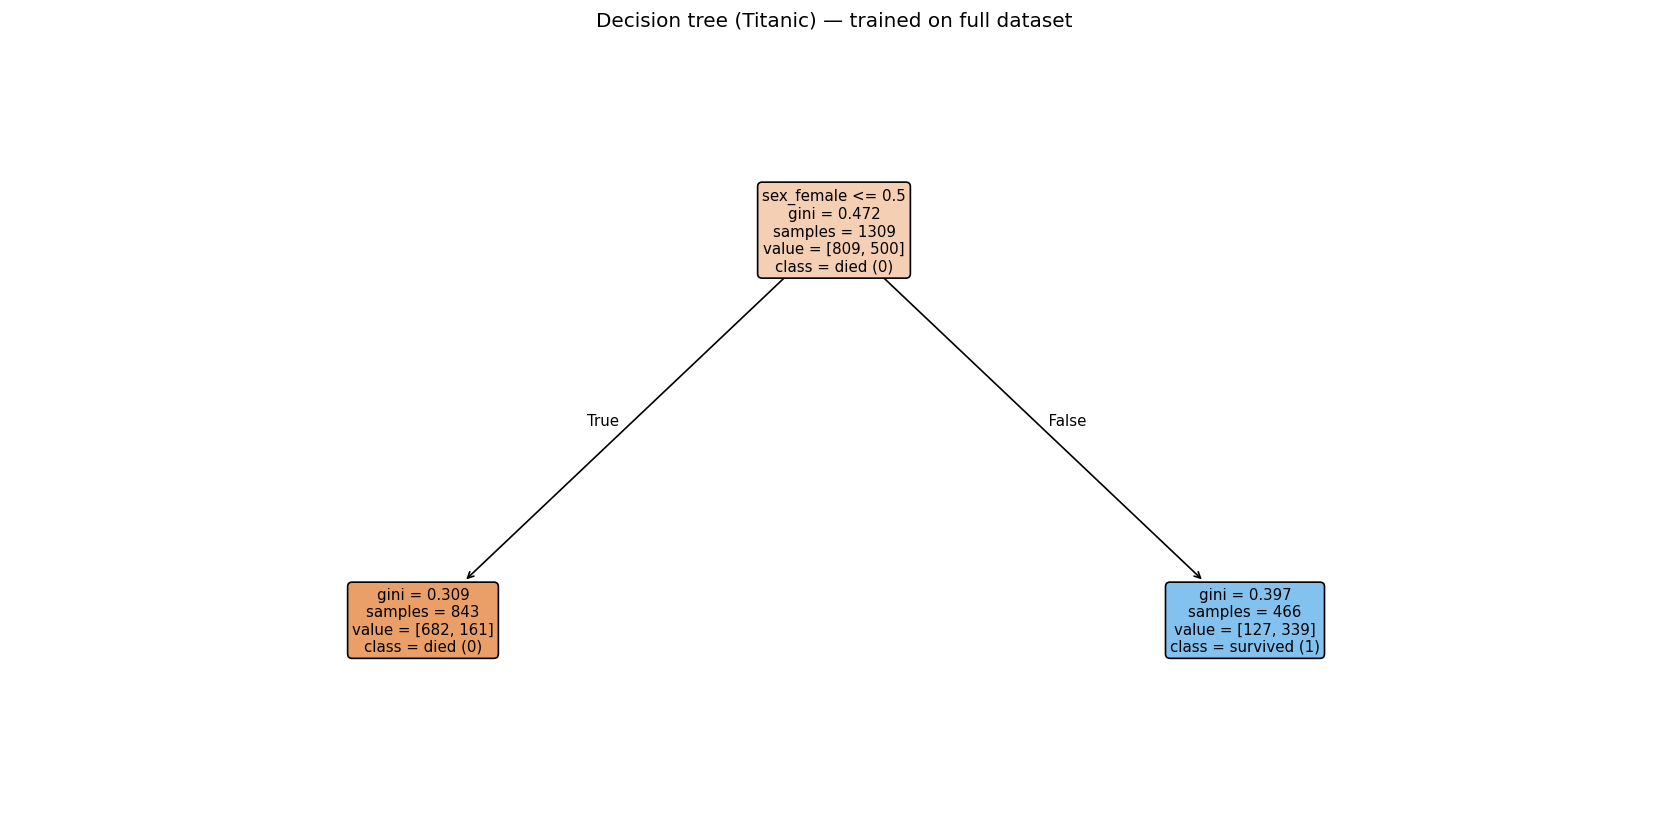

In [24]:
from sklearn import tree

# Fit a decision tree classifier to the Titanic data
tree_clf = DecisionTreeClassifier(random_state=42, max_depth=1)
tree_clf.fit(X, y)
tree_preds = tree_clf.predict(X)
tree_acc = accuracy_score(y, tree_preds)
print(f"Decision tree accuracy on the same data: {tree_acc:.2f}") 

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7), dpi=120)
tree.plot_tree(
  tree_clf,
  feature_names=list(X.columns),
  class_names=["died (0)", "survived (1)"],
  filled=True,
  rounded=True,
  fontsize=9,
)
plt.title("Decision tree (Titanic) — trained on full dataset")
plt.tight_layout()
plt.show()

### Interpreting Gini and the Diagram

- **Gini impurity** measures how mixed the labels are in a node: $G = 1 - \sum_k p_k^2$, where $p_k$ is the fraction of samples from class $k$. A pure node (all `0` or all `1`) has $G = 0$.
- Each box shows: the split rule, the impurity (`gini`), how many samples reach that node (`samples`), the class counts (`value`), and the predicted class (`class`).
- Reading the tree top to bottom mirrors the decision process: start at the root question, follow the branch that matches a passenger’s features, and stop at a leaf to see the final prediction.


**Why not celebrate yet?** Training and evaluating on the same data can hide overfitting. A deep tree can memorize every row (100% accuracy) but fail on new scenarios. To know how a model will generalize, we need to hold out data the model never sees during training.


### Train / Validation / Test Splits

- **Training set**: used to learn the model parameters.
- **Validation set**: used to tune choices like tree depth or learning rate without touching the test set.
- **Test set**: only used once, at the end, to estimate performance on truly unseen data.

A common recipe is 70% train, 15% validation, 15% test (ratios vary). Guard against **data leakage**, which happens when information from the validation or test set sneaks into training—this makes the model look better than it really is.


<p align="center">
  <img src="../../files/train_val_test_split.webp" alt="Train/Validation/Test Split Diagram">
</p>


---
# Golden Rule of Supervised ML:

### **The test data cannot influence the training phase in any way!**
---


### ✏️ Exercise: Train/Validation/Test Split

#### **Prompt:**

Split the prepared feature matrix X and label vector y into training, validation, and test sets using scikit-learn. First, perform a stratified train–test split to reserve 30% of the data for temporary holdout, using a fixed random_state for reproducibility. Then split this temporary set evenly into validation and test sets, again using stratification to preserve class balance. Finally, print the number of rows in the training, validation, and test sets with clear, readable messages suitable for teaching.


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)
print(f"Train size: {len(X_train)} rows")
print(f"Validation size: {len(X_val)} rows")
print(f"Test size: {len(X_test)} rows")

Train size: 916 rows
Validation size: 196 rows
Test size: 197 rows


### ✏️ Exercise: Train and Evaluate a Decision Tree Model

#### **Prompt:**

Train and evaluate a small decision tree model on the Titanic dataset using predefined training, validation, and test splits. Assume X_train, X_val, X_test, y_train, y_val, and y_test already exist. Create a DecisionTreeClassifier with a fixed random_state and a limited maximum depth (such as 3), fit it on the training data, and compute accuracy on the training, validation, and test sets using accuracy_score. Finally, summarize the results in a small pandas DataFrame with one row per data split and a corresponding accuracy value, keeping the output clear and suitable for instructional purposes.


In [10]:
titanic_tree = DecisionTreeClassifier(random_state=42, max_depth=3)
titanic_tree.fit(X_train, y_train)
train_acc = accuracy_score(y_train, titanic_tree.predict(X_train))
val_acc = accuracy_score(y_val, titanic_tree.predict(X_val))
test_acc = accuracy_score(y_test, titanic_tree.predict(X_test))

pd.DataFrame(
    {
        "Split": ["Train", "Validation", "Test"],
        "Accuracy": [train_acc, val_acc, test_acc]
    }
)

,Split,Accuracy
0,Train,0.810191
1,Validation,0.805344
2,Test,0.835878


### ✏️ Exercise: Visualize Decision Tree Performance and Feature Importance

#### **Prompt:**

Visualize the performance of a trained decision tree classifier on the Titanic dataset using the test split. Assume a fitted model `titanic_tree` and the test data `X_test` and `y_test` already exist. First, generate predictions on the test set and display a confusion matrix using scikit-learn with clearly labeled classes (“died (0)” and “survived (1)”), a blue color map, integer counts, and a descriptive title. Then compute the model’s feature importances, identify the most influential features (for example, the top 15), and visualize them as a horizontal bar chart with clear axis labels and a readable title. Use matplotlib for all visualizations and keep the figures clean, interpretable, and suitable for instructional use.


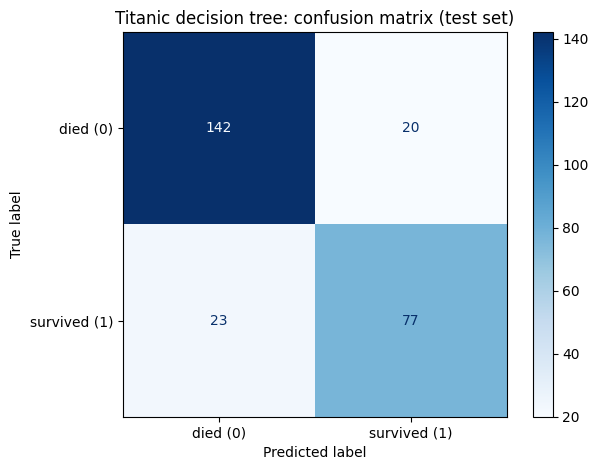

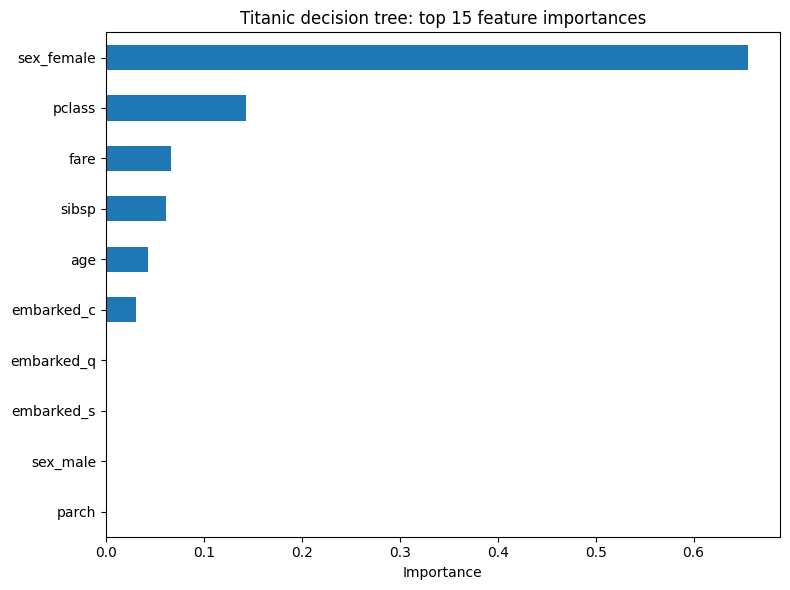

In [11]:
# Visualize classifier results: confusion matrix + feature importances
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred_test = titanic_tree.predict(X_test)

# Confusion matrix (test set)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["died (0)", "survived (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Titanic decision tree: confusion matrix (test set)")
plt.tight_layout()
plt.show()

# Feature importances (top 15)
importances = pd.Series(titanic_tree.feature_importances_, index=X.columns).sort_values(ascending=False)
top_k = 15
ax = importances.head(top_k).sort_values().plot(kind="barh", figsize=(8, 6))
ax.set_title(f"Titanic decision tree: top {top_k} feature importances")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

**Reflection prompt:** If your validation accuracy is much higher than test accuracy, what might be happening? How would you investigate it?


### Visualizing the Decision Tree

Decision trees are popular because they are interpretable: you can literally see each split and explain predictions to teammates. Visualizing the trained tree helps confirm whether the splits match our intuition.


### ✏️ Exercise: Visualize the Trained Decision Tree

#### **Prompt:**

Visualize the structure of a trained decision tree model for the Titanic dataset. Assume a fitted `DecisionTreeClassifier` named `titanic_tree` and a feature matrix `X` already exist. Create a clear, readable plot of the tree using scikit-learn’s tree visualization utilities, including feature names from `X` and class names labeled as “died (0)” and “survived (1)”. Use filled and rounded nodes, a reasonable font size, and an appropriate figure size to ensure the visualization is easy to interpret. Add a descriptive title and format the layout so the plot is suitable for teaching and discussion.


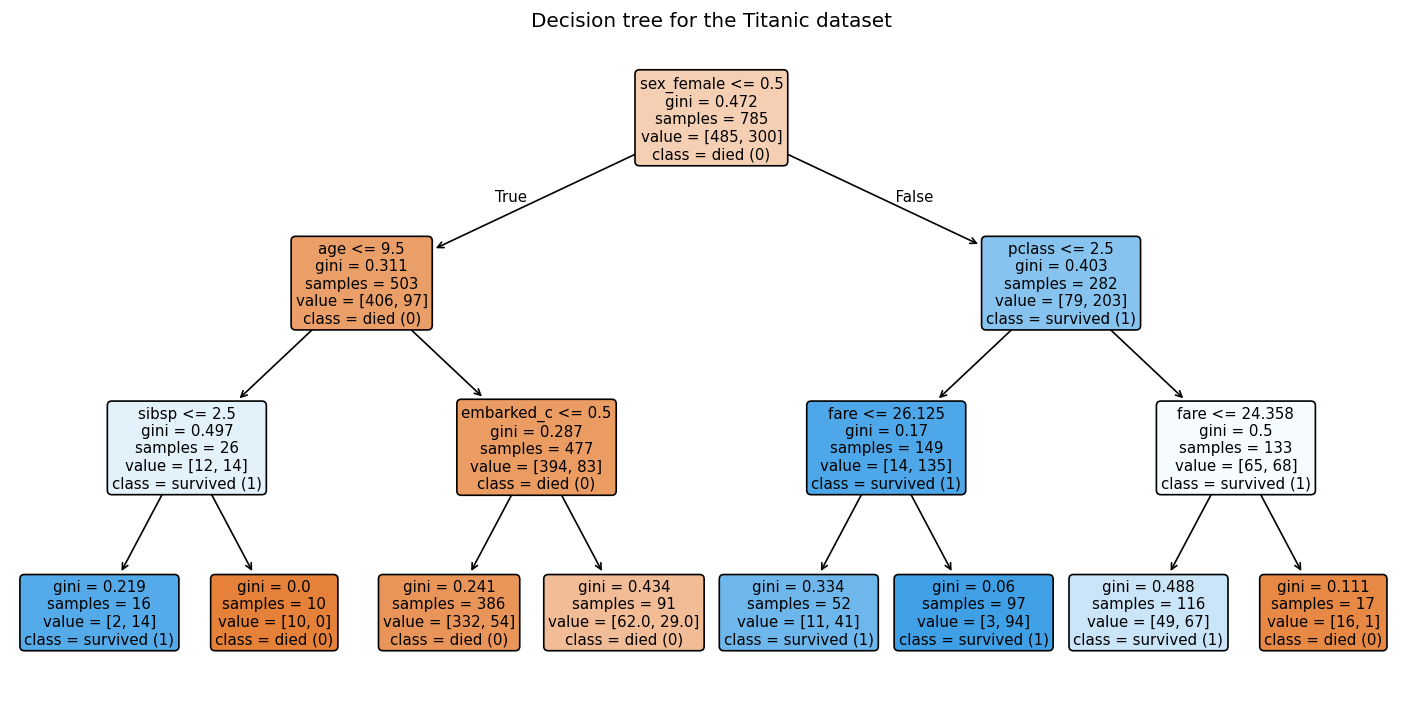

In [25]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(12, 6), dpi=120)
tree.plot_tree(
    titanic_tree,
    feature_names=list(X.columns),
    class_names=["died (0)", "survived (1)"],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Decision tree for the Titanic dataset")
plt.tight_layout()
plt.show()

## A Classic Dataset! (Iris Dataset)

To build confidence, let’s repeat the same workflow on the classic Iris flower dataset included in scikit-learn. The steps—split, train, validate, test—stay the same regardless of dataset size.
The Iris dataset is a classic multivariate dataset containing **150 iris flowers** from **three species**:

- _setosa_ (label `0`)
- _versicolor_ (label `1`)
- _virginica_ (label `2`)

Each row corresponds to a **single flower** and includes **four numeric features** (all in centimeters):

- `sepal length (cm)`
- `sepal width (cm)`
- `petal length (cm)`
- `petal width (cm)`

In scikit-learn, the dataset is provided as a `Bunch` object with:

- `data`: a `(150, 4)` feature matrix (`X_iris`)
- `target`: a length‑150 vector of integer labels (`y_iris`)
- `feature_names`: list of the four feature names
- `target_names`: array mapping `0, 1, 2` → `"setosa"`, `"versicolor"`, `"virginica"`

In this notebook, we:

- Built a **scatter-matrix** (`fig`) to visualize how the three species separate across pairs of features.
- Split the data into **train**, **validation**, and **test** sets (`X_train_i`, `X_val_i`, `X_test_i`, etc.).
- Trained a **DecisionTreeClassifier** (`iris_tree`) and evaluated it with accuracy on each split.
- Computed a **confusion matrix** (`iris_cm`) to see how well the model distinguishes the three species; the current tree achieves **near-perfect (in our run, perfect) accuracy** on the test set.

Because it is small, clean, and well-behaved (no missing values, balanced classes, simple numeric features), the Iris dataset is ideal for practicing supervised learning workflows: **split → train → validate → test**, interpreting decision trees, and comparing different classifiers.


![Iris Flowers Feature illustration](../../files/iris-flowers.png)


### ✏️ Exercise: Explore Feature Relationships in the Iris Dataset

#### **Prompt:**

Create an interactive visualization to explore relationships between features in the Iris dataset. Load the Iris dataset using scikit-learn and assume access to both the feature data and target labels. Construct a pandas DataFrame that includes the feature values and a human-readable species label mapped from the target indices. Use Plotly Express to generate a scatter matrix showing pairwise relationships between all numeric features, color-coded by species. Customize the plot with a clear title, clean axis labels (removing units such as “(cm)” where appropriate), and hide the diagonal plots to reduce clutter. Ensure the visualization is interactive, readable, and suitable for instructional exploration of multivariate data.


In [ ]:
import plotly.express as px
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
X_iris = iris.data
y_iris = iris.target

iris_df = iris.frame.copy()
iris_df["species"] = iris_df["target"].map(lambda idx: iris.target_names[idx])

fig = px.scatter_matrix(
  iris_df,
  dimensions=iris.feature_names,
  color="species",
  title="Iris dataset feature relationships",
  labels={col: col.replace(" (cm)", "") for col in iris.feature_names}
)
fig.update_traces(diagonal_visible=False)
fig.show()

### Data Preprocessing (and why it matters)

Before training a model, we often **preprocess** the data so the learning algorithm gets clean, consistent inputs.

Common preprocessing steps:

1. **Select features + label** (define what $X$ and $y$ are).
2. **Fix data types** (e.g., strings → numbers when appropriate).
3. **Handle missing values** (impute or drop).
4. **Encode categorical variables** (e.g., one-hot encoding).
5. **Scale/standardize numeric features** (important for many models).
6. **Split into train/validation/test** without leakage.

**Important note:** Decision trees usually _do not require_ feature scaling, but models like **logistic regression**, **SVMs**, and **k-NN** often do. Using a `Pipeline` keeps preprocessing and modeling bundled together correctly (and helps prevent leakage).


In [34]:
import pandas as pd
import re
import plotly.express as px
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# ---- Preprocess: min–max scaling ----
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_iris)

X_proc = pd.DataFrame(X_scaled, columns=X_iris.columns)

# ---- Add human-readable species label ----
df_viz = X_proc.copy()
df_viz["species"] = y_iris.map(lambda i: iris.target_names[i])

# ---- Clean axis labels ----
def clean_feature_name(name: str) -> str:
    name = re.sub(r"\s*\(.*?\)\s*", "", name)
    name = name.replace("sepal ", "Sepal ").replace("petal ", "Petal ")
    name = name.replace("length", "Length").replace("width", "Width")
    return name.strip()

label_map = {c: clean_feature_name(c) for c in X_proc.columns}
df_viz = df_viz.rename(columns=label_map)
feature_cols = [label_map[c] for c in X_proc.columns]

# ---- Scatter matrix visualization ----
fig = px.scatter_matrix(
    df_viz,
    dimensions=feature_cols,
    color="species",
    title="Iris Dataset (Min–Max Scaled): Pairwise Feature Relationships",
    opacity=0.85,
    height=750,
)

fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title_x=0.5,
    legend_title_text="Species",
    dragmode="select",
)

fig.show()

### ✏️ Exercise: Train and Evaluate a Decision Tree on the Iris Dataset (with preprocessing)

#### **Prompt:**

Use the Iris dataset to practice a clean supervised-learning workflow with preprocessing. Assume the previous cell already created `X_train_i`, `X_val_i`, `X_test_i`, `y_train_i`, `y_val_i`, and `y_test_i` from the Iris features/labels.

1. Build a preprocessing + model `Pipeline` that imputes missing numeric values with the median (even if there are none) and then trains a `DecisionTreeClassifier` with a fixed `random_state` and limited `max_depth` (such as 3).
2. Fit the pipeline on the training set.
3. Compute accuracy on the train, validation, and test sets using `accuracy_score`.
4. Summarize the results in a small pandas DataFrame with one row per split and its corresponding accuracy.
5. Create a clear, readable plot of the trained tree using scikit-learn’s visualization utilities, with feature names from the Iris dataset and class names (setosa/versicolor/virginica).


In [ ]:
# Train, evaluate, and visualize a Decision Tree on the Iris dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y,
)

# -----------------------------
# 3) Train Decision Tree
# -----------------------------
clf = DecisionTreeClassifier(
    random_state=0,
    max_depth=3,       # small depth keeps the tree interpretable for instruction
)
clf.fit(X_train, y_train)

# -----------------------------
# 4) Evaluate
# -----------------------------
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# -----------------------------
# 5) Visualize evaluation: confusion matrix
# -----------------------------
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot()
plt.title("Iris Decision Tree: Confusion Matrix (Test Set)")
plt.show()

# -----------------------------
# 6) Visualize model: decision tree structure
# -----------------------------
plt.figure(figsize=(14, 8))
plot_tree(
    clf,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
    rounded=True,
    impurity=True,
)
plt.title("Decision Tree Classifier (max_depth=3) — Iris Dataset")
plt.tight_layout()
plt.show()

# -----------------------------
# 7) Visualize feature importance
# -----------------------------
importances = pd.Series(clf.feature_importances_, index=iris.feature_names).sort_values(ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(importances.index, importances.values)
plt.title("Decision Tree Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [150, 1309]

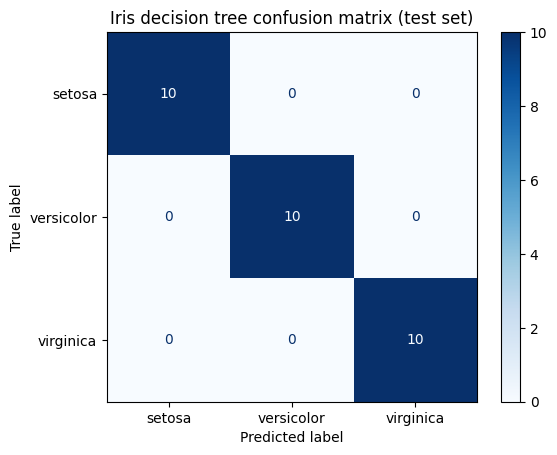

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import tree

# Confusion matrix using the full preprocessing+model pipeline
iris_cm = confusion_matrix(y_test_i, iris_tree_pipe.predict(X_test_i))
disp = ConfusionMatrixDisplay(confusion_matrix=iris_cm, display_labels=iris.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Iris decision tree confusion matrix (test set)")
plt.tight_layout()
plt.show()

# Visualize the trained decision tree (model is inside the pipeline)
plt.figure(figsize=(12, 6), dpi=120)
tree.plot_tree(
    iris_tree_pipe.named_steps["model"],
    feature_names=[c.replace(" (cm)", "") for c in X_iris.columns],
    class_names=list(iris.target_names),
    filled=True,
    rounded=True,
    fontsize=9,
)
plt.title("Iris decision tree (depth=3) — with preprocessing pipeline")
plt.tight_layout()
plt.show()

### Mini-Assignment

1. Add 1–2 new features to the trolley dataset (ideas: `is_night`, `has_obstacle_on_b`) and briefly justify how they could influence a decision. Re-train the tree and describe any changes you observe.
2. Re-train the decision tree with at least two different `max_depth` values (e.g., 2 vs. 5) and compare validation accuracy. Which depth would you keep and why?
3. In 3–5 sentences, explain why we keep the test set untouched until the end and what could go wrong if we peek at it early.

**Stretch goal:** Try a different classifier (e.g., logistic regression) on the trolley data and compare its validation/test accuracy with the tree.
